In [1]:
from matplotlib import pyplot as plt
import scipy.io # Reads in matlab data files
import pandas as pd # Save csv files
#import scipy # Continuous wavelet transform
from scipy import signal as scipy_signals# Continuous wavelet transform
import numpy as np
import random
from sklearn.utils import shuffle

# Imports for the model
import torch.nn as nn
from torchsummary import summary


# Load in and partitioning the data

In [2]:
# A class to store/manipulate the loaded data
class bb_sample:
    
    def __init__(self, fault_loc, file_data):
        self.fault_type = fault_loc
        # Parse the data to get the DE and FE signals
        keys = file_data.keys()
        for k in keys:
            if 'DE' in k:
                self.DE = file_data[k]
                print(self.DE[0:3].T)
            if 'FE' in k:
                self.FE = file_data[k]

In [3]:
data = []
path = 'CWR/'
files = []
subdir = 'baseline/'
subdir_path = path + subdir
for file in range(4):
    data_path = subdir_path + 'N_' + str(file) + '.mat'
    file_data = scipy.io.loadmat(data_path)
    data.append(bb_sample('N', file_data))
subdir = '12k/'
subdir_path = path + subdir
loc = ['B', 'I']
sizes = ['7','14','21','28']
for l in loc:
    type_path = subdir_path + l
    for s in sizes:
        size_path = type_path + s + '_'
        for sample in range(4):
            data_path = size_path + str(sample) + '.mat'
            file_data = scipy.io.loadmat(data_path)
            data.append(bb_sample(l, file_data))

[[0.05319692 0.08866154 0.09971815]]
[[ 0.046104   -0.03713354 -0.089496  ]]
[[ 0.046104   -0.03713354 -0.089496  ]]
[[ 0.06425354  0.06300185 -0.00438092]]
[[0.01460308 0.05444862 0.10764554]]
[[-0.0027614  -0.09632403  0.11370459]]
[[-0.0721212   0.30310395  0.03313677]]
[[-0.31447441  0.12198878  0.39146866]]
[[ 0.09031393  0.22497265 -0.10883154]]
[[-0.46781317  0.17900351  0.48129529]]
[[ 0.00552279 -0.10379605 -0.04548184]]
[[0.0688725  0.04288287 0.05360359]]
[[ 0.1054204  -0.10736962 -0.16340974]]
[[-0.00795932  0.02533988  0.00016244]]
[[ 0.23000814  0.18858719 -0.42622978]]
[[ 0.25404854 -0.05003002 -0.01315725]]
[[ 0.07244607  0.04791836 -0.25079984]]
[[-0.2652988  1.6219034 -0.0358072]]
[[ 1.6381794 -3.084302  -0.9228492]]
[[-1.6894488  0.166829   2.4218688]]
[[-6.5584142  4.0616758  7.613099 ]]
[[-0.08300435 -0.19573433  0.23341928]]
[[-0.27760164 -0.04434479  0.11760303]]
[[-0.09323776  0.1872877   0.21766307]]
[[ 0.22269856  0.09323776 -0.14651649]]
[[-0.22383561 -0.2095

# Vibration Images

In [4]:
def vibration_image(vi_signal):
    side_length = np.sqrt(len(vi_signal))
    if round(side_length) != side_length:
        print('Signal length must be a square value')
    else:
        # Min shift 0
        #print('min: ' + str(np.min(vi_signal)))
        vi_signal -= np.min(vi_signal)
        # Normalize to [0, 2]
        #print('min: ' + str(np.min(vi_signal)))
        d = (np.max(vi_signal) / 2)
        vi_signal /= d
        #print('max: ' + str(np.max(vi_signal)))
        # Normalize to [-1, 1]
        vi_signal -= 1
        side_length = int(side_length)
        img = np.zeros((side_length, side_length))
        for row in range(side_length):
            #temp = signal[row*side_length:row*side_length+side_length].reshape(-1)
            #print(type(temp))
            #print(temp)
            img[row] = vi_signal[row*side_length:row*side_length+side_length].reshape(-1)
        #print(img.shape)
        return img

## Plot Vibration Images

In [5]:
imgs = []
total_size = 40000
for d in data:
    signal = d.DE
    used_data = 0
    while used_data + total_size < len(signal):
        img = vibration_image(signal[used_data:used_data + total_size])
        imgs.append(img)
        used_data += total_size

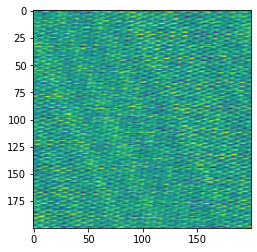

In [9]:
# Change the index here to change which image is being shown
plt.imshow(imgs[len(imgs)-len(imgs)])

In [405]:
np.max(imgs[100])

1.0

# Signals Proccesing

## Raw Signal

In [132]:
def raw_signal(signal):
    return signal

## Frequency Filtered Signal

In [248]:
# Still working on this
def frequency_filter(sig):
    order = 3
    sos = scipy_signals.butter(order, [28.333, 30], btype='bandpass', fs=12000, output='sos')
    return scipy_signals.sosfilt(sos, sig)

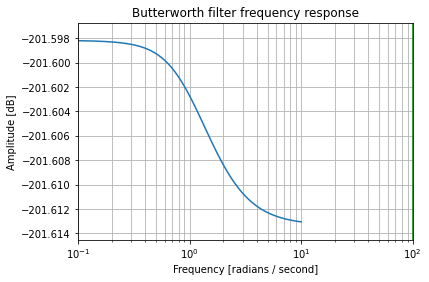

In [247]:
order = 3
b, a = scipy_signals.butter(order, [28.333, 30], btype='bandpass', fs=12000)
w, h = scipy_signals.freqs(b,a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

## Wavelet Decomposition

This is a transformation that gives multiresolution of the original image in both the time and frequency domains. Below is the function and a plot of the mother wavelet we used

In [208]:
def wavelet_transform(sig):
    widths = np.arange(20, 40)
    return scipy_signals.cwt(sig.reshape(-1), scipy_signals.ricker, widths)

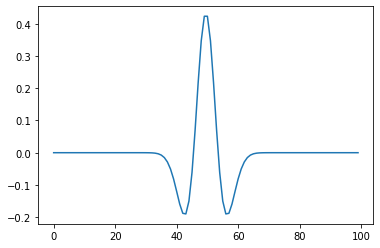

In [249]:
points = 100
a = 4.0
vec2 = scipy_signals.ricker(points, a)
plt.plot(vec2)
plt.show()

## Plot Processed Signals

In [359]:
imgs = []
total_size = 400
for d in data:
    signal = d.DE
    used_data = 0
    while used_data + total_size < len(signal):
        #img = raw_signal(signal[used_data:used_data + total_size])
        #img = wavelet_transform(signal[used_data:used_data + total_size])
        img = frequency_filter(signal[used_data:used_data + total_size])
        imgs.append(img)
        used_data += total_size

KeyboardInterrupt: 

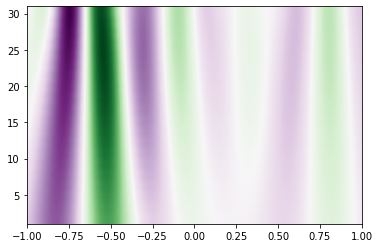

In [212]:
# Change the index here to change which image is being shown
plt.imshow(imgs[1], extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto')

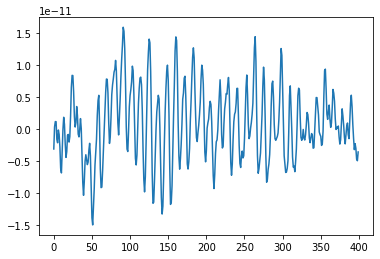

In [238]:
plt.plot(imgs[1])

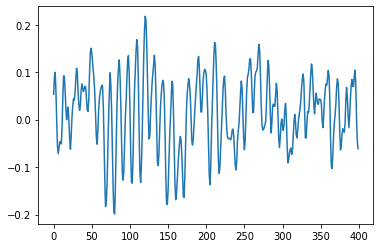

In [239]:
plt.plot(data[0].DE[0:400])

# Partition the data into different schemes that ML model can be trained on

## Partition Scheme

In the paper, it is presented where a sample (vibration image or signal in our case) can appear in both the training and validation set for a model. We think this is problematic because it may allow a model to overfit on the training data. Instead, each run of the experiment can only be in one fold. This type of partitioning is more rigorous and commonly done in cinical studies where a patient can't appear in both the training and validation sets [I have sources for this].

In [11]:
def partition_data(data, sample_length = 400, preprocess=vibration_image):
    file_data = []
    for d in data:
        signal = d.DE
        used_data = 0
        file_samples = []
        while used_data + sample_length < len(signal):
            sample = [None ,d.fault_type]
            sample_signal = preprocess(signal[used_data:used_data + sample_length])
            sample[0] = sample_signal
            file_samples.append(sample)
            used_data += sample_length
        file_data.append(file_samples)
    return file_data

In [27]:
file_data = partition_data(data, sample_length = 35*35)

In [28]:
for f in range(len(file_data)):
    print((file_data[f][0][0][0,0:3]))

[0.20941884 0.37975952 0.43286573]
[ 0.27817093 -0.15623299 -0.42950463]
[ 0.34976526  0.342723   -0.03638498]
[0.06675308 0.31432275 0.6448477 ]
[ 0.05431755 -0.21309192  0.38718663]
[-0.18498528  0.9484789   0.1329735 ]
[-0.84661143  0.29509242  1.        ]
[ 0.06364393  0.40848586 -0.44633943]
[-0.93476821  0.38377483  1.        ]
[-0.07686373 -0.20667374 -0.13742887]
[ 0.01486682 -0.01817056 -0.00454264]
[ 0.20781335 -0.26605173 -0.39084825]
[-0.10216069 -0.01615272 -0.08118313]
[ 0.1746551   0.13838714 -0.39994311]
[ 0.80285412 -0.18657505 -0.06659619]
[ 0.18071329  0.12054194 -0.61227336]
[-0.07919774  0.21895089 -0.04294163]
[ 0.28539888 -0.56873712 -0.17780394]
[-0.24872435 -0.00108566  0.2997503 ]
[-0.95082059  0.51111858  1.        ]
[-0.18339261 -0.29070666  0.11782898]
[-0.23923552 -0.02565628  0.12262958]
[-0.14165957  0.0845504   0.10904447]
[ 0.15783281  0.07257849 -0.0853078 ]
[-0.10699653 -0.09312953  0.44516231]
[0.04005097 0.08956854 0.10795558]
[0.01466837 0.0563775

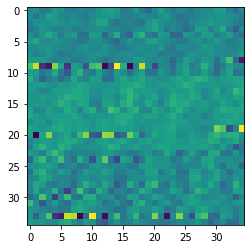

In [36]:
plt.imshow(file_data[27][0][0])

### Save the data to files

This is used to save data to different directories depednging on how it was partitioned and which experiments it can be used on.

In [37]:
### Save these images on my computer
for f in range(len(file_data)):
    print(str(f) + ':' + str(file_data[f][0][1]) + ',')
    subdir = 'CWR/vibration_images/1225/' + str(f) + '/'
    for im in range(len(file_data[f])):
        img = file_data[f][im][0]
        img_data = np.asarray(img)
        np.savetxt( subdir + str(im) + '.csv', img_data, delimiter=',')

0:N,
1:N,
2:N,
3:N,
4:B,
5:B,
6:B,
7:B,
8:B,
9:B,
10:B,
11:B,
12:B,
13:B,
14:B,
15:B,
16:B,
17:B,
18:B,
19:B,
20:I,
21:I,
22:I,
23:I,
24:I,
25:I,
26:I,
27:I,
28:I,
29:I,
30:I,
31:I,
32:I,
33:I,
34:I,
35:I,


In [470]:
data[0].DE

array([[ 0.20941884],
       [ 0.37975952],
       [ 0.43286573],
       ...,
       [-0.03463015],
       [ 0.01668923],
       [ 0.04693846]])

In [471]:
data[1].DE

array([[ 0.27817093],
       [-0.15623299],
       [-0.42950463],
       ...,
       [-0.09909231],
       [-0.10827138],
       [-0.07092923]])

In [272]:
def cv_split(file_data, folds=5):
    np.arange(len(file_data))
    data_files_per_fold = round(len(file_data)/folds)
    test_file_indices = np.random.choice(indices, size=data_files_per_fold)
    train_X, train_y, test_X, test_y = [], [], [], []
    for f in range(len(file_data)):
        experiment_imgs = file_data[f]
        for sample in experiment_imgs:
            if f in test_file_indices:
                test_X.append(sample[0])
                test_y.append(sample[1])
            else:
                train_X.append(sample[0])
                train_y.append(sample[1])
    # Shuffle the arrays to give random orders
    t_X, t_y = shuffle(train_X, train_y)
    v_X, v_y = shuffle(test_X, test_y)
    return t_X, t_y, v_X, v_y

# Machine Learning Models

Using the data partitions from above, out goal is to train a neural network to classify the data using multiple preprocessing steps. We will compare the performance of these algorithms in terms of:
1. Prediction quality (how good of a classifier it is)
2. Complexity (models with fewer parameters are better)
3. Speed (faster models are better)

In [328]:
### Build 2D CNN
num_kernels_1 = 30
num_kernels_1 = 60
model_2d = nn.Sequential(
            nn.Conv2d(1, num_kernels_1, 5),
            #nn.
            nn.ReLU(True),
            nn.Conv2d(12, 12 * 2, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(12 * 2, 12 * 4, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(12 * 4, 12 * 2, 4, 2, 1),
            nn.ReLU(True)
        )

In [334]:
input_n = file_data[0][0][0]
input = tf.convert_to_tensor(input_n, np.float32)
m = nn.Conv2d(1, num_kernels_1, 5)
output = m(input)

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not tensorflow.python.framework.ops.EagerTensor

In [338]:
type(tf.convert_to_tensor(input_n))

tensorflow.python.framework.ops.EagerTensor

In [339]:
type(tf.constant([1,2,3]))

tensorflow.python.framework.ops.EagerTensor

In [310]:
m = nn.AvgPool2d((2, 2))
input = torch.randn(4, 4, 1)
print(input)
m(input)

tensor([[[ 0.6369],
         [ 0.1795],
         [-1.1135],
         [-2.1646]],

        [[-0.4398],
         [ 0.9004],
         [ 1.1260],
         [-0.5666]],

        [[ 0.6997],
         [ 0.9986],
         [ 0.3360],
         [-0.5272]],

        [[ 0.0379],
         [ 0.6205],
         [ 0.5791],
         [-0.7660]]])


RuntimeError: Given input size: (4x4x1). Calculated output size: (4x2x0). Output size is too small

In [ ]:
### Build 1D CNN

In [294]:
import torch.nn as nn
from torchsummary import summary

In [291]:
x = nn.Sequential(
            nn.ConvTranspose2d(12 * 2, 12 * 4, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(12 * 4, 12 * 2, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(12 * 2, 12 * 1, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(12 * 1, 3, 4, 2, 1),
            nn.ReLU(True),
        )

In [295]:
summary(x, [(24, 4, 4)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 48, 8, 8]          18,480
              ReLU-2             [-1, 48, 8, 8]               0
   ConvTranspose2d-3           [-1, 24, 16, 16]          18,456
              ReLU-4           [-1, 24, 16, 16]               0
   ConvTranspose2d-5           [-1, 12, 32, 32]           4,620
              ReLU-6           [-1, 12, 32, 32]               0
   ConvTranspose2d-7            [-1, 3, 64, 64]             579
              ReLU-8            [-1, 3, 64, 64]               0
Total params: 42,135
Trainable params: 42,135
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 0.16
Estimated Total Size (MB): 0.68
----------------------------------------------------------------


In [282]:
k_folds = 5

predictions = []
for fold in range(k_folds):
    train_X, train_y, test_X, test_y = cv_split(file_data, folds=k_folds)
    
    #####################################################################
    ###                                                               ###
    ###  TODO: build and train the model on train_X & train_y         ###
    ###                                                               ###
    #####################################################################
    
    #####################################################################
    ###                                                               ###
    ###  TODO: test the model on test_X and compare prediciton with   ###
    ###        test_y                                                 ###
    ###                                                               ###
    #####################################################################
    

In [283]:
len(test_X)

8498

In [285]:
len(test_y)

8498

In [286]:
len(train_X)

34594

In [287]:
len(train_y)

34594